In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow import keras
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Lambda, SimpleRNN, LSTM

In [2]:
def evaluate_model(model, X_val, y_val):
    forecast_val = model.predict(X_val)
    mae_val = mean_absolute_error(y_val, forecast_val)
    mse_val = mean_squared_error(y_val, forecast_val)
    return mae_val, mse_val

def plot_predictions(forecast_val, y_val, title="Baseline model plot"):
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_val, label='Predicted Validation')
    plt.plot(y_val, label='Actual Validation')
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
# 1. Load the Apple closing stock price from Yahoo Finance
tickerSymbol = 'AAPL'
df = yf.Ticker(tickerSymbol)
df = df.history(period='1d', start='2013-01-01', end='2023-01-01')
df.index = pd.to_datetime(df.index)
# Change the datetime format
df.index = df.index.strftime('%Y-%m-%d')
df=df[['Close']]
df.head()

,Close
Date,
2013-01-02,16.791187
2013-01-03,16.579241
2013-01-04,16.117428
2013-01-07,16.022629
2013-01-08,16.065744


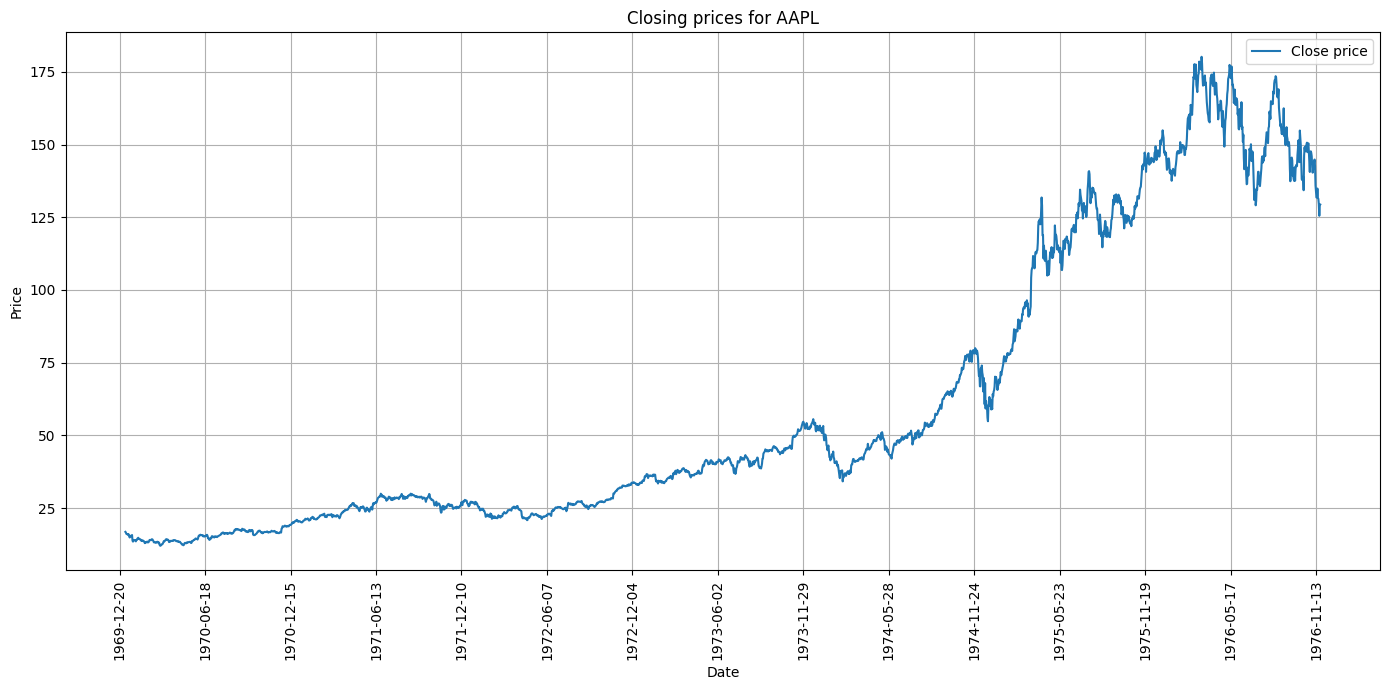

In [4]:
# Plot the data
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Close'], label='Close price')
plt.title('Closing prices for AAPL')
plt.xlabel('Date')
plt.ylabel('Price')

# Set x-ticks at 180-day intervals
locator = mdates.DayLocator(interval=180)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# Rotate x labels to 90 degrees
plt.xticks(rotation=90)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
data = df['Close'].values

# Sliding window
window_size = 20
X, y = [], []
for i in range(window_size, len(data)):
    X.append(data[i-window_size:i])
    y.append(data[i])

X = np.array(X)
y = np.array(y)

# Train/val split
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Dataset using tf.data
batch_size = 128
buffer_size = 10000

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

#DNN

In [6]:
# Model
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(window_size,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Fit model
history = model.fit(train_data, epochs=100, verbose=0)

16/16 [==============================] - 0s 2ms/step


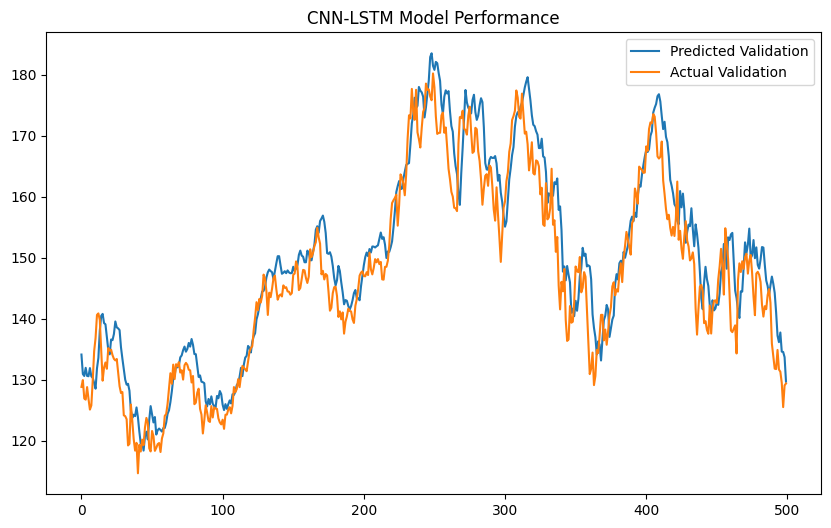

16/16 [==============================] - 0s 2ms/step
MAE: 4.510892166137696, MSE: 32.63803781192482


In [7]:
# plot
forecast = model.predict(X_val)
plot_predictions(forecast, y_val, title="CNN-LSTM Model Performance")
# evaluate
mae, mse = evaluate_model(model, X_val, y_val)
print(f'MAE: {mae}, MSE: {mse}')



#CNN

In [8]:
# Reshape data for CNN, RNN, LSTM, CNN-LSTM
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)
# Dataset using tf.data
batch_size = 128
buffer_size = 10000

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Build CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4), loss='mse')

# Train model
model.fit(train_data, epochs=100, verbose=0)

16/16 [==============================] - 0s 2ms/step


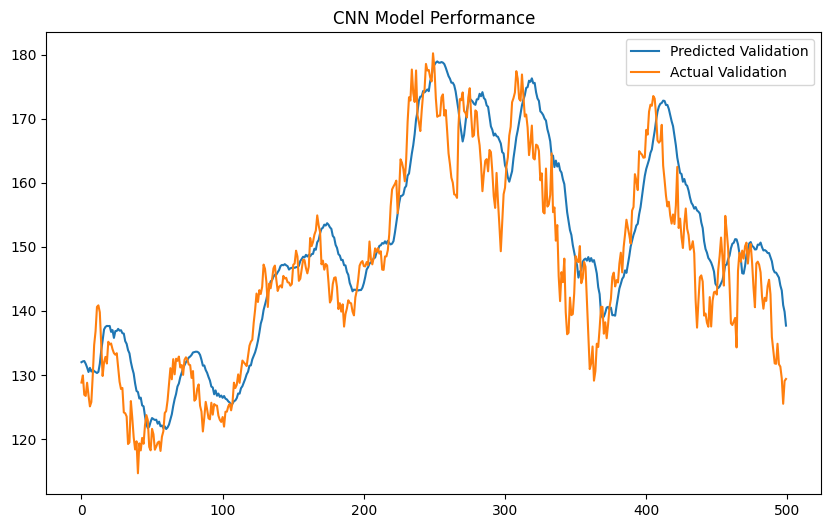

16/16 [==============================] - 0s 2ms/step
MAE: 5.904710540771484, MSE: 54.036926954486404


In [9]:
# plot
forecast = model.predict(X_val)
plot_predictions(forecast, y_val, title="CNN Model Performance")
# evaluate
mae, mse = evaluate_model(model, X_val, y_val)
print(f'MAE: {mae}, MSE: {mse}')



#RNN

In [10]:
# Build RNN model
model = Sequential()
model.add(SimpleRNN(64, activation='relu', return_sequences=True, input_shape=(window_size, 1)))
model.add(SimpleRNN(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Fit model
model.fit(train_data, epochs=100, verbose=0)

16/16 [==============================] - 0s 3ms/step


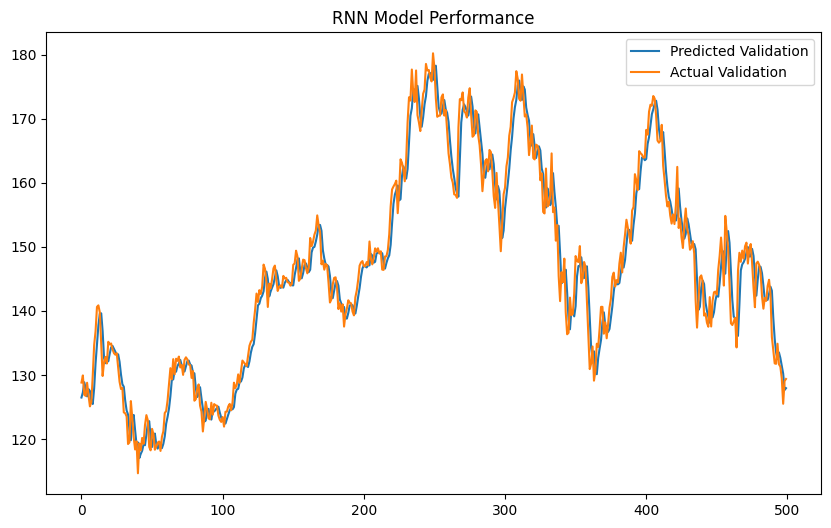

16/16 [==============================] - 0s 3ms/step
MAE: 2.4490821533203126, MSE: 9.763313441976207


In [11]:
# plot
forecast = model.predict(X_val)
plot_predictions(forecast, y_val, title="RNN Model Performance")
# evaluate
mae, mse = evaluate_model(model, X_val, y_val)
print(f'MAE: {mae}, MSE: {mse}')


#LSTM

In [12]:
# Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

# Train model
model.fit(train_data, epochs=100, verbose=0)

16/16 [==============================] - 0s 4ms/step


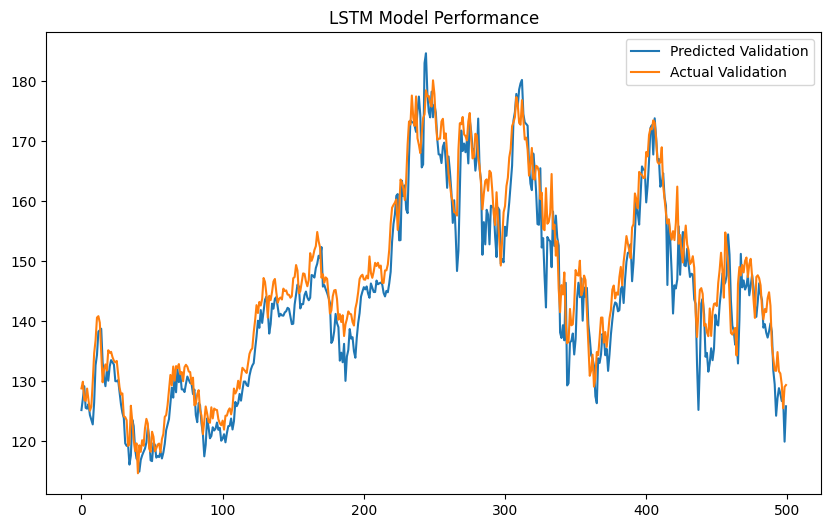

16/16 [==============================] - 0s 4ms/step
MAE: 3.79260009765625, MSE: 22.936077898507005


In [13]:
# plot
forecast = model.predict(X_val)
plot_predictions(forecast, y_val, title="LSTM Model Performance")
# evaluate
mae, mse = evaluate_model(model, X_val, y_val)
print(f'MAE: {mae}, MSE: {mse}')


#CNN-LSTM

In [20]:
# Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=[window_size, 1]),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1)
])

# Compile model with optimizer and loss
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

# Fit model
history = model.fit(train_data, epochs=100, verbose=0)

16/16 [==============================] - 1s 7ms/step


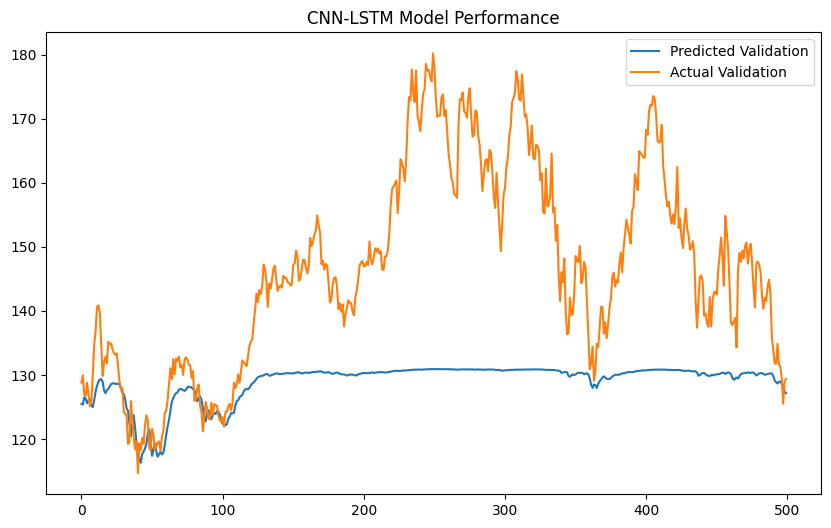

16/16 [==============================] - 0s 8ms/step
MAE: 17.796389389038087, MSE: 490.1978798830245


In [21]:
# plot
forecast = model.predict(X_val)
plot_predictions(forecast, y_val, title="CNN-LSTM Model Performance")
# evaluate
mae, mse = evaluate_model(model, X_val, y_val)
print(f'MAE: {mae}, MSE: {mse}')
